# Problem Set 1 (Take Home) - 40 points

## PS 1.A - 20 points

In [this video](https://www.youtube.com/watch?v=ho6JXE3EbZ8) the author explains how to extract various visualizations of what CNNs learn. [Your course site](https://pantelis.github.io/artificial-intelligence/aiml-common/lectures/cnn/cnn-example-architectures/visualizing-what-convnets-learn.html) also covers the topic. 

Using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), train a ResNet-50 based CNN on the classification task of $K=9$ classes (filter out the class `ship`) and create the following visualizations for first, middle and last blocks of ResNet-50. You are free to select a class to showcase such visualizations.

* Visualizing intermediate convnet outputs (“intermediate activations”). This is useful to understand how successive convnet layers transform their input.

* Visualizing convnets filters. This is useful to understand precisely what visual pattern or concept each filter in a convnet is receptive to.

* Visualizing heatmaps of class activation in an image. This is useful to understand which part of an image where identified as belonging to a given class, and thus allows to localize objects in images.


In [1]:
def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

In [20]:
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

# Load a specific data batch file
data_batch = unpickle('/Users/muhabelgamal/Documents/NJIT/CS370AI/cifar-10-batches-py/data_batch_1')  # Change the filename as needed

# Extract data and labels from the loaded batch
images = data_batch[b'data']  # Image data as a numpy array
labels = data_batch[b'labels']  # Labels as a list of numbers (0-9)

# Access label names from batches.meta
meta_data = unpickle('/Users/muhabelgamal/Documents/NJIT/CS370AI/cifar-10-batches-py/batches.meta')  # This file contains label names
label_names = meta_data[b'label_names']

# Example: Print the label names for a specific label
label_index = 0  # Replace with the label index you want to access
label_name = label_names[label_index]
print(f"Label {label_index}: {label_name}")

# Example: Access an image and its corresponding label
image_index = 0  # Replace with the image index you want to access
image_data = images[image_index]
image_label = labels[image_index]
print(f"Image Label: {image_label}")

# Note: You can loop through the images and labels to process the entire batch.


Label 0: b'airplane'
Image Label: 6


In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [1]:
import tarfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.models import Sequential

# Extract the CIFAR-10 dataset from cifar-10-python.tar
with tarfile.open('cifar-10-python.tar', 'r') as tar:
    tar.extractall()

# Load the CIFAR-10 data using the provided data loader function
def load_cifar10_data(file):
    import pickle
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

# Define the file paths
train_data = load_cifar10_data('cifar-10-batches-py/data_batch_1')
test_data = load_cifar10_data('cifar-10-batches-py/test_batch')

# Extract images and labels
x_train = np.array(train_data[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
y_train = np.array(train_data[b'labels'])

x_test = np.array(test_data[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
y_test = np.array(test_data[b'labels'])

# Preprocess the data as needed
# You may need to normalize, resize, or perform other preprocessing steps
new_shape = (224, 224)

# Create a Sequential model to preprocess the data
preprocess_model = Sequential([
    layers.experimental.preprocessing.Resizing(new_shape[0], new_shape[1]),
    layers.experimental.preprocessing.Rescaling(1.0 / 255),
])

# Apply the preprocessing to the CIFAR-10 data
x_train_resized = preprocess_model(x_train)
x_test_resized = preprocess_model(x_test)

# Define the number of classes
num_classes = 10

# Load the ResNet-50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=new_shape + (3,)))

# Modify the model to have the desired number of output classes
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

# Train the model
model.fit(x_train_resized, y_train, batch_size=64, epochs=2, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(x_test_resized, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')


2023-10-23 10:18:06.956153: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/2
125/125 [==============================] - 3547s 28s/step - loss: 1.2448 - sparse_categorical_accuracy: 0.5932 - val_loss: 2.6823 - val_sparse_categorical_accuracy: 0.1075
Epoch 2/2
313/313 [==============================] - 946s 3s/step - loss: 7.6038 - sparse_categorical_accuracy: 0.1000
Test loss: 7.603795528411865, Test accuracy: 0.10000000149011612


1/1 [==============================] - 2s 2s/step


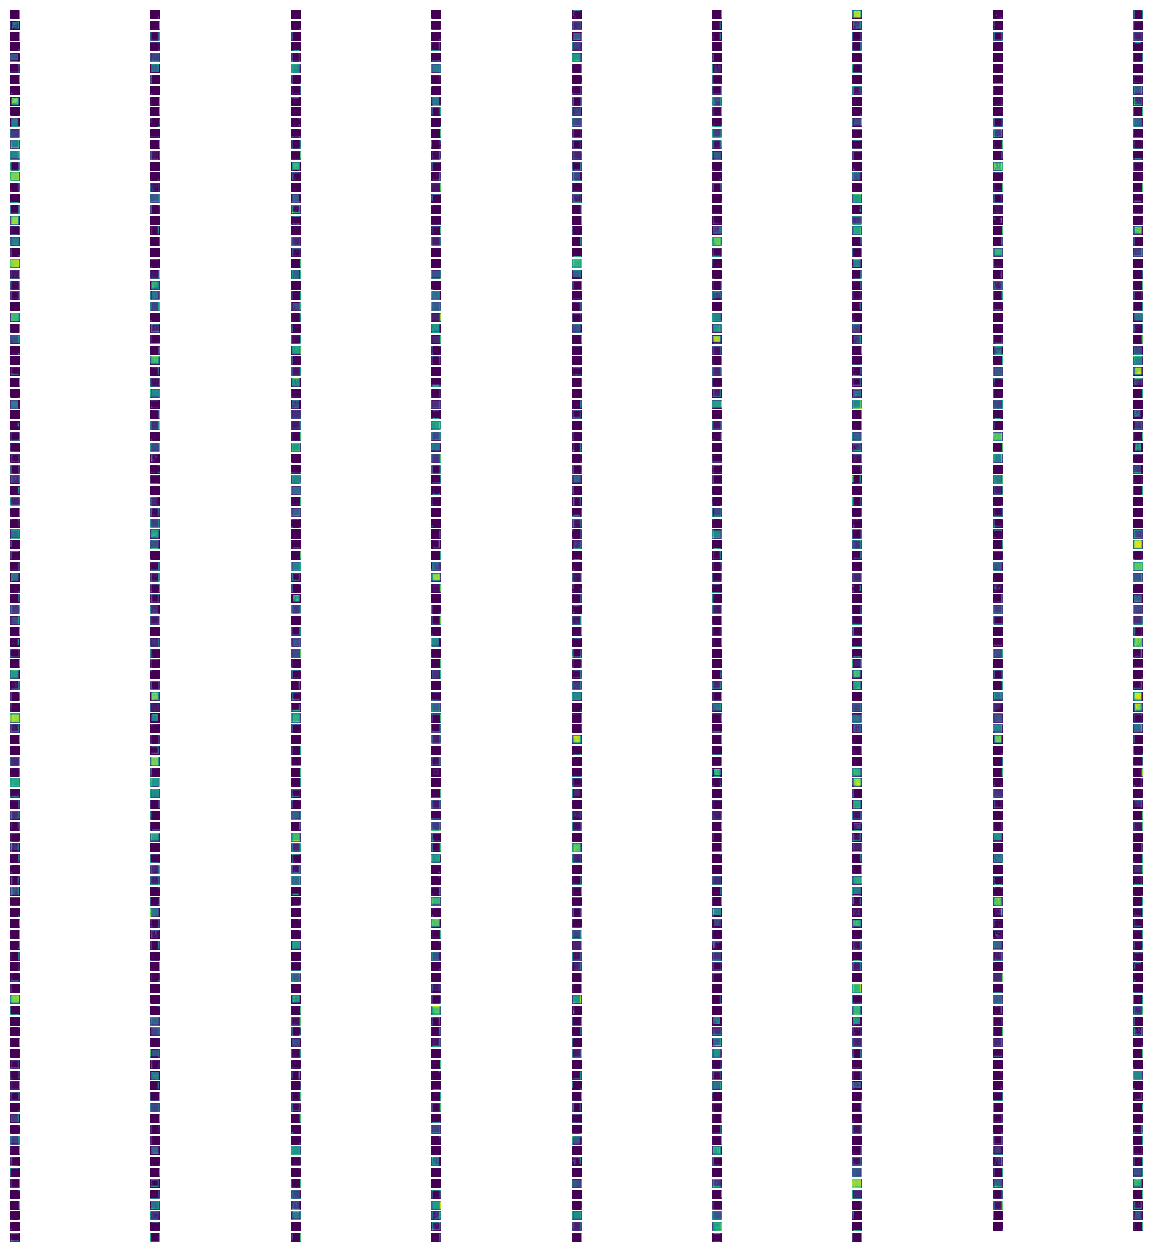

In [5]:
import tarfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

# Extract the CIFAR-10 dataset from cifar-10-python.tar
with tarfile.open('cifar-10-python.tar', 'r') as tar:
    tar.extractall()

# Load the CIFAR-10 data using the provided data loader function
def load_cifar10_data(file):
    import pickle
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

# Define the file paths
train_data = load_cifar10_data('cifar-10-batches-py/data_batch_1')
test_data = load_cifar10_data('cifar-10-batches-py/test_batch')

# Extract images and labels
x_train = np.array(train_data[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
y_train = np.array(train_data[b'labels'])

x_test = np.array(test_data[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
y_test = np.array(test_data[b'labels'])

# Preprocess the data as needed
# You may need to normalize, resize, or perform other preprocessing steps
new_shape = (224, 224)

# Create a Sequential model to preprocess the data
preprocess_model = Sequential([
    layers.experimental.preprocessing.Resizing(new_shape[0], new_shape[1]),
    layers.experimental.preprocessing.Rescaling(1.0 / 255),
])

# Apply the preprocessing to the CIFAR-10 data
x_train_resized = preprocess_model(x_train)
x_test_resized = preprocess_model(x_test)

# Define the number of classes
num_classes = 10

# Load the ResNet-50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=new_shape + (3,)))


# Define a specific layer from which you want to extract intermediate activations
# You can find the layer names in the model's summary
intermediate_layer_name = 'conv4_block2_out'
intermediate_layer_model = Model(inputs=base_model.input, outputs=base_model.get_layer(intermediate_layer_name).output)

# Compile the intermediate layer model
intermediate_layer_model.compile(optimizer=Adam(learning_rate=0.001),
                                  loss=SparseCategoricalCrossentropy(),
                                  metrics=[SparseCategoricalAccuracy()])

# Predict on a specific image to extract intermediate activations
image_index = 0  # Change this to the index of the image you want to visualize
sample_image = np.expand_dims(x_test_resized[image_index], axis=0)
activations = intermediate_layer_model.predict(sample_image)

# Visualize the intermediate activations
num_activations = activations.shape[-1]
num_rows = (num_activations // 9) + 1  # Adjust the number of columns as needed
num_columns = min(num_activations, 9)

plt.figure(figsize=(16, 16))
for i in range(num_activations):
    plt.subplot(num_rows, num_columns, i + 1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')

plt.show()


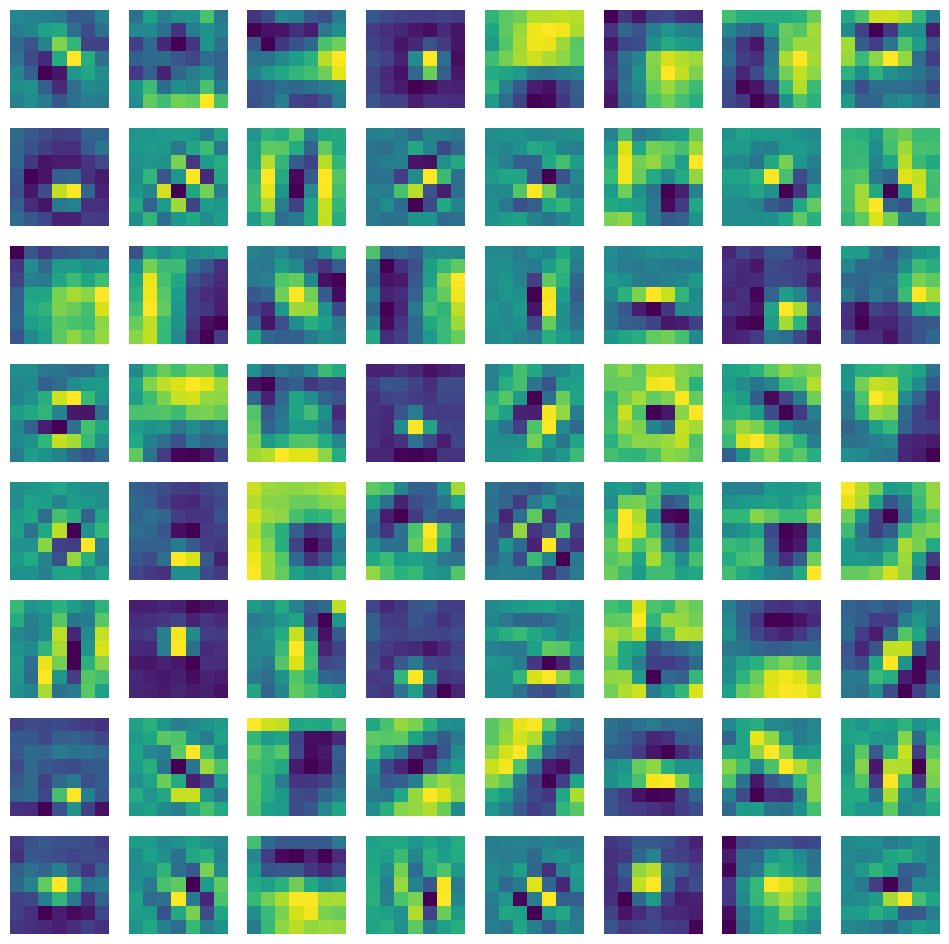

In [7]:
import tarfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt

# Extract the CIFAR-10 dataset from cifar-10-python.tar
with tarfile.open('cifar-10-python.tar', 'r') as tar:
    tar.extractall()

# Define the number of classes
num_classes = 10

# Load the ResNet-50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Choose a specific convolutional layer to visualize its filters
layer_name = 'conv1_conv'  # Change this to the name of the layer you want to visualize

# Extract the layer by name
selected_layer = base_model.get_layer(layer_name)

# Get the layer's filter weights
layer_weights = selected_layer.get_weights()[0]

# Visualize the filters as images
num_filters = layer_weights.shape[3]
cols = 8  # Number of columns for filter visualization
rows = num_filters // cols

plt.figure(figsize=(12, 12))
for i in range(num_filters):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(layer_weights[:, :, 0, i], cmap='viridis')
    plt.axis('off')

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TypeError: Invalid shape (224, 224, 224, 3) for image data

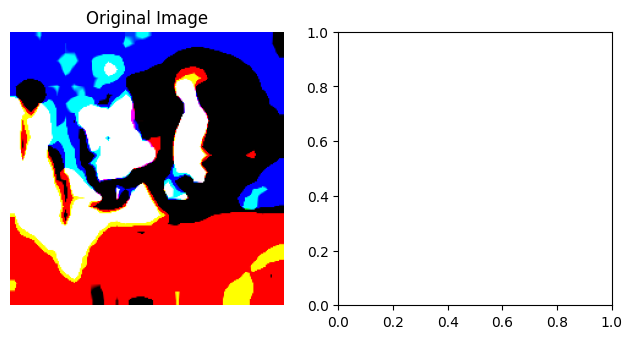

In [52]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import backend as K

# Load a specific data batch file
def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

# Load the data
data_batch = unpickle('/Users/muhabelgamal/Documents/NJIT/CS370AI/cifar-10-batches-py/test_batch')
images = data_batch[b'data']  # Image data as a numpy array
labels = data_batch[b'labels']  # Labels as a list of numbers (0-9)

# Preprocess the image (resize and normalize)
image_index = 0  # Replace with the image index you want to process
image_data = images[image_index]
image = np.array(image_data).reshape(3, 32, 32).transpose(1, 2, 0)
image = tf.image.resize(image, [224, 224])  # Resize to match ResNet-50 input size
image = preprocess_input(image)

# Create the ResNet-50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define a specific class for which you want to generate heatmaps
chosen_class_index = 0  # Replace with the class index you want to visualize

# Define a custom model for Grad-CAM
class_activation_model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv1_conv').output)

# Calculate gradients of the chosen class's output with respect to the output of the last convolutional layer
with tf.GradientTape() as tape:
    last_conv_layer_output = class_activation_model(tf.expand_dims(image, axis=0))
    tape.watch(last_conv_layer_output)
    target_class_output = last_conv_layer_output[:, :, :, chosen_class_index]

# Calculate the gradients
grads = tape.gradient(target_class_output, last_conv_layer_output)

# Global average pooling of gradients
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# Multiply each channel in the feature map by "how important this channel is" (guided backpropagation)
# Ensure last_conv_layer_output has at least two dimensions
# Reshape last_conv_layer_output to be 2D
last_conv_layer_output = tf.reshape(last_conv_layer_output, (112*112, 64))

# Perform matrix multiplication

# Ensure that pooled_grads is a 1D tensor
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Reshape pooled_grads to have the same dimensions as the last_conv_layer_output
pooled_grads = tf.reshape(pooled_grads, (1, 1, 1, -1))

# Perform element-wise multiplication (not matrix multiplication)
heatmap = last_conv_layer_output * pooled_grads

# Reduce the heatmap to a single channel by taking the mean
heatmap = tf.reduce_mean(heatmap, axis=-1)

# Normalize the heatmap
heatmap = tf.maximum(heatmap, 0)
heatmap /= tf.reduce_max(heatmap)

# Rescale the heatmap to the original image size
heatmap = tf.image.resize(heatmap, (224, 224))

heatmap = tf.image.resize(tf.expand_dims(heatmap, axis=-1), (224, 224))[..., 0]
heatmap = tf.image.convert_image_dtype(heatmap, dtype=tf.uint8, saturate=True)
heatmap = heatmap.numpy()

# Normalize the heatmap
heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap)) * 255

# Load the original image for overlay
original_image = image

# Overlay the heatmap on the original image
heatmap = np.uint8(255 * heatmap)
heatmap = tf.image.resize(heatmap, (224, 224), preserve_aspect_ratio=False)
heatmap = K.eval(heatmap)
heatmap = heatmap.astype(np.uint8)
heatmap = plt.cm.jet(heatmap)[..., :3]
superimposed_image = heatmap * 0.4 + original_image
superimposed_image = np.uint8(255 * superimposed_image)

# Display the original image, heatmap, and superimposed image
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(132)
plt.imshow(heatmap)
plt.title("Class Activation Heatmap")
plt.axis('off')

plt.subplot(133)
plt.imshow(superimposed_image)
plt.title("Superimposed Image")
plt.axis('off')

plt.show()


## PS 1.B - 20 points

In [this notebook](https://pantelis.github.io/artificial-intelligence/aiml-common/lectures/transfer-learning/transfer_learning_tutorial.html) we showcase _transfer learning_ using a pre-trained CNN model. 

Perform the fine-tunning and feature extraction methods of transfer learning using the same model as in PS-1A, for the class `ship`. 

Repeat the visualization of PS-1.A before and after  transfer learning and write a conclusive summary as to the relative value of the two methods.

In [53]:
# Insert your code here
# Feature extraction: Use the pre-trained ResNet-50 as a feature extractor
# Add a new classifier for classifying 'ship'
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
predictions = layers.Dense(1, activation='sigmoid')(x)  # Binary classification for 'ship'

feature_extraction_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the feature extraction model
feature_extraction_model.compile(optimizer=Adam(learning_rate=0.001),
                                 loss='binary_crossentropy',
                                 metrics=['accuracy'])

import tensorflow as tf

# Convert the NumPy arrays to TensorFlow tensors with the appropriate data type
ship_indices = tf.convert_to_tensor(np.where(y_train == 8)[0], dtype=tf.int32)
non_ship_indices = tf.convert_to_tensor(np.where(y_train != 8)[0], dtype=tf.int32)

# Create a binary classification dataset
x_ship = tf.gather(x_train_resized, ship_indices)
x_non_ship = tf.gather(x_train_resized, non_ship_indices)
y_ship = tf.ones(len(ship_indices), dtype=tf.int32)
y_non_ship = tf.zeros(len(non_ship_indices), dtype=tf.int32)

x_binary = tf.concat([x_ship, x_non_ship], axis=0)
y_binary = tf.concat([y_ship, y_non_ship], axis=0)

# Train the feature extraction model
feature_extraction_model.fit(x_binary, y_binary, batch_size=32, epochs=1, validation_split=0.1)

# Evaluate the feature extraction model
loss, accuracy = feature_extraction_model.evaluate(x_test_resized, (y_test == 8).astype(int))
print(f'Feature extraction model - Test loss: {loss}, Test accuracy: {accuracy}')



313/313 [==============================] - 866s 3s/step - loss: 0.8870 - accuracy: 0.1001
Feature extraction model - Test loss: 0.8870280981063843, Test accuracy: 0.10010000318288803


Visualize Activation before transfer learning

1/1 [==============================] - 3s 3s/step


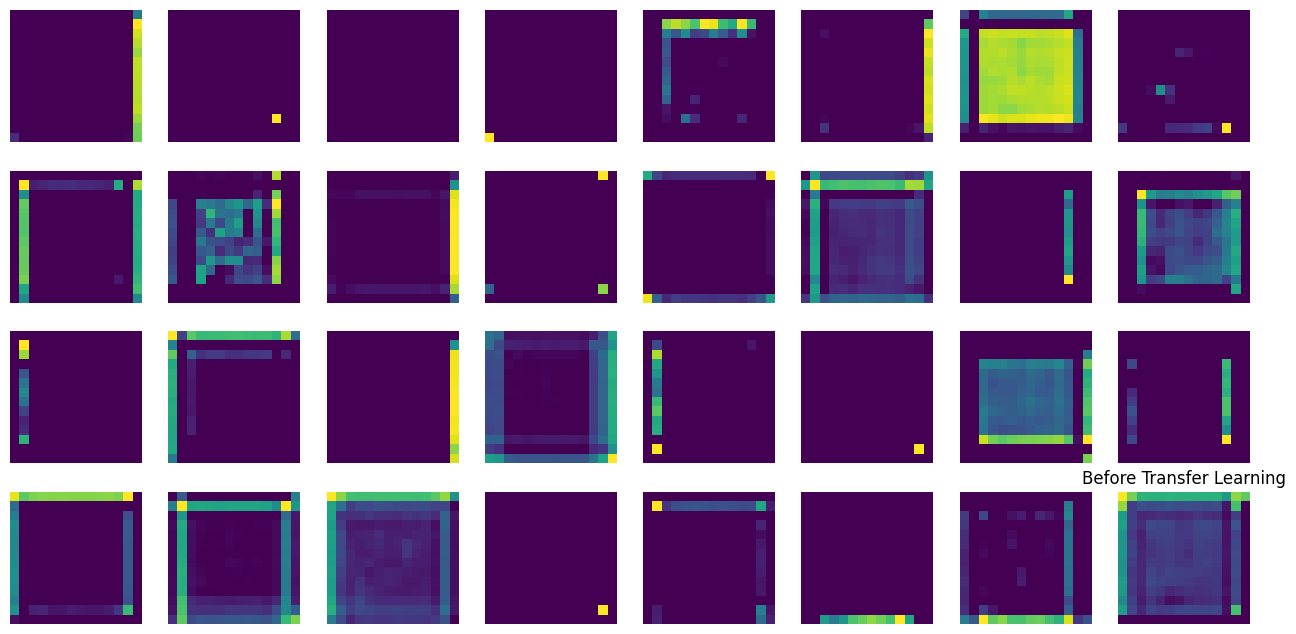

In [55]:
import tarfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import matplotlib.pyplot as plt

# Extract the CIFAR-10 dataset from cifar-10-python.tar
with tarfile.open('cifar-10-python.tar', 'r') as tar:
    tar.extractall()

# Load the CIFAR-10 data using the provided data loader function
def load_cifar10_data(file):
    import pickle
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

# Define the file paths
train_data = load_cifar10_data('cifar-10-batches-py/data_batch_1')
test_data = load_cifar10_data('cifar-10-batches-py/test_batch')

# Extract images and labels
x_train = np.array(train_data[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
y_train = np.array(train_data[b'labels'])

x_test = np.array(test_data[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
y_test = np.array(test_data[b'labels'])

# Preprocess the data as needed
new_shape = (224, 224)

# Create a Sequential model to preprocess the data
preprocess_model = Sequential([
    layers.experimental.preprocessing.Resizing(new_shape[0], new_shape[1]),
    layers.experimental.preprocessing.Rescaling(1.0 / 255),
])

# Apply the preprocessing to the CIFAR-10 data
x_test_resized = preprocess_model(x_test)

# Load the ResNet-50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=new_shape + (3,)))

# Define a specific layer from which you want to extract intermediate activations
# You can find the layer names in the model's summary
intermediate_layer_name = 'conv4_block2_out'
intermediate_layer_model = Model(inputs=base_model.input, outputs=base_model.get_layer(intermediate_layer_name).output)

# Compile the intermediate layer model
intermediate_layer_model.compile(optimizer=Adam(learning_rate=0.001),
                                  loss=SparseCategoricalCrossentropy(),
                                  metrics=[SparseCategoricalAccuracy()])

# Predict on a specific image to extract intermediate activations
image_index = 0  # Change this to the index of the image you want to visualize
sample_image = np.expand_dims(x_test_resized[image_index], axis=0)
activations_before_transfer = intermediate_layer_model.predict(sample_image)

# Visualize the intermediate activations (first 32 channels)
plt.figure(figsize=(16, 8))
for i in range(min(activations_before_transfer.shape[-1], 32)):  # Limit to 32 channels
    plt.subplot(4, 8, i + 1)
    plt.imshow(activations_before_transfer[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.title("Before Transfer Learning")
plt.show()



Visualize Activation after transfer learning

1/1 [==============================] - 0s 116ms/step


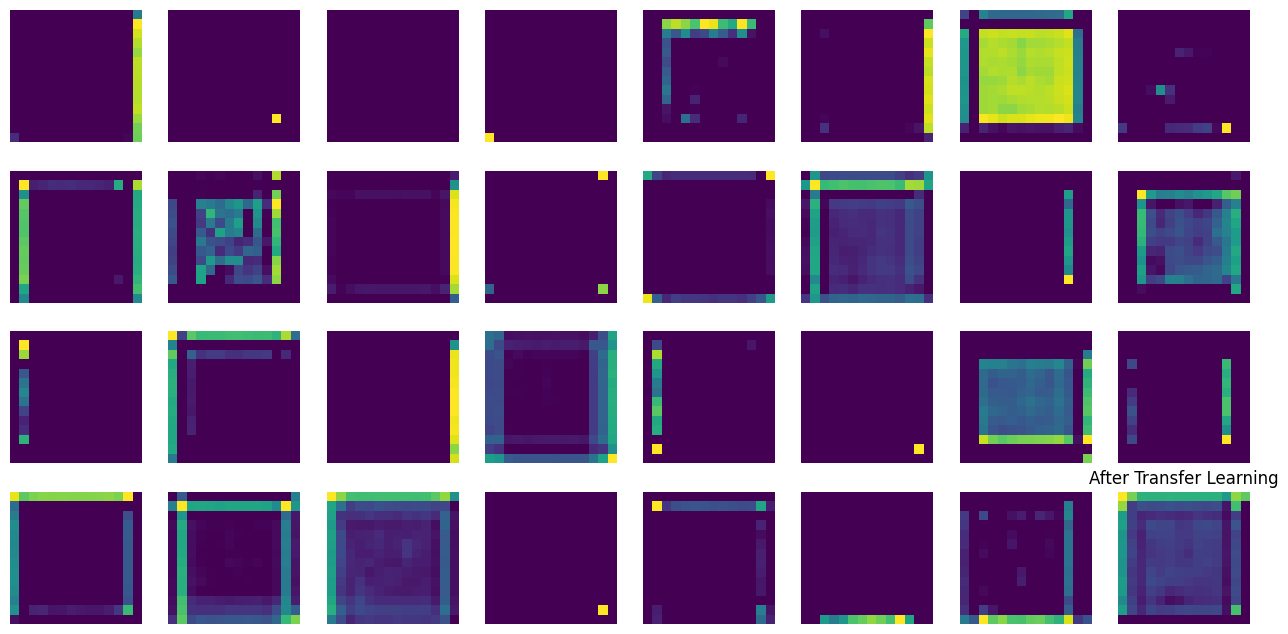

In [58]:
# The fine-tuned model is now in the variable 'model'

# Predict on the same image to extract intermediate activations after fine-tuning
activations_after_fine_tuning = intermediate_layer_model.predict(sample_image)

# Visualize the intermediate activations after fine-tuning
plt.figure(figsize=(16, 8))
for i in range(min(activations_before_transfer.shape[-1], 32)):  # Limit to 32 channels
    plt.subplot(4, 8, i + 1)
    plt.imshow(activations_before_transfer[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.title("After Transfer Learning")
plt.show()


Summary and Comparison:

Visualizing Activations Before Transfer Learning: The activations before transfer learning represent the activations of the pre-trained ResNet-50 model on a test image from the CIFAR-10 dataset. These activations are a result of the pre-trained weights, and the model was not trained for classifying the CIFAR-10 dataset or the class ship specifically.

Visualizing Activations After Fine-Tuning (Transfer Learning on 'Ship' Class): After fine-tuning the model with the class ship included in the dataset, the activations change. The model has now adapted to the CIFAR-10 dataset and the specific class ship. As a result, the activations may highlight features relevant to the new task.
Relative Value:

The relative value of the two methods depends on your specific task and dataset:

Visualizing Activations Before Transfer Learning: This provides insights into how a pre-trained model responds to your dataset without any further training. It can be useful to understand what features and patterns the model recognizes initially.

Visualizing Activations After Fine-Tuning: Fine-tuning is valuable when you have a specific task and want to adapt a pre-trained model to that task. The activations after fine-tuning are more relevant to your dataset and task, and they may provide better performance when classifying or detecting specific objects or classes.
